In [1]:
import numpy as np
import pandas as pd 
from itertools import combinations
import random

In [2]:
df = pd.read_csv(r'/kaggle/input/deep-essays-dataset/essays_sorted.csv', header=0)
df = df[['essay', 'authors']]
df

,essay,authors
0,Omer Bonne means well; that much is certain. A...,Angela Chen
1,Here’s a test you might enjoy: rate these scen...,Jacob Burak
2,Human beings crave all sorts of things: coffee...,Zoey Lavallee
3,I hear a single voice as I walk up the steps t...,Rebecca Ruiz
4,Here’s what I remember about the first time I ...,Carrie Arnold
...,...,...
2230,"If you want to understand rich people, talk to...",Brooke Harrington
2231,"When Andrew Russell became a teenager, he took...",Jamie McCallum
2232,Work means everything to us Americans. For cen...,James Livingston
2233,"Work is no longer working for us. Or, for most...",Tyler Re


In [3]:
import pandas as pd
from itertools import combinations
import random

def transform_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms a pandas DataFrame with 'essay' and 'authors' columns
    into a new DataFrame with 'text1', 'text2', and 'same_author' columns.

    The 'same_author' column will be 1 if text1 and text2 are by the same author,
    and 0 otherwise. The dataset is balanced to have at least 10,000 rows
    for each category ('same_author' and 'different_author') by resampling
    with replacement if necessary.

    Args:
        df (pd.DataFrame): The input DataFrame with 'essay' and 'authors' columns.

    Returns:
        pd.DataFrame: The transformed DataFrame with balanced categories.
    """
    if 'essay' not in df.columns or 'authors' not in df.columns:
        raise ValueError("Input DataFrame must contain 'essay' and 'authors' columns.")

    # Create a list of (essay, author) tuples
    essay_author_pairs = list(df[['essay', 'authors']].itertuples(index=False, name=None))

    same_author_pairs = []
    diff_author_pairs = []

    # Generate all unique combinations of two essays and categorize them
    # We use combinations to avoid duplicate pairs (e.g., (A, B) and (B, A))
    # and to avoid comparing an essay with itself.
    for (essay1, author1), (essay2, author2) in combinations(essay_author_pairs, 2):
        pair_data = {
            "text1": essay1,
            "text2": essay2,
            "same_author": 1 if author1 == author2 else 0
        }
        if author1 == author2:
            same_author_pairs.append(pair_data)
        else:
            diff_author_pairs.append(pair_data)

    target_rows_per_category = 3000
    transformed_data = []

    # Process 'same_author' pairs
    if len(same_author_pairs) < target_rows_per_category:
        if len(same_author_pairs) > 0:
            # Resample with replacement to reach target_rows_per_category
            sampled_same_author = random.choices(same_author_pairs, k=target_rows_per_category)
            print(f"Warning: Only {len(same_author_pairs)} unique 'same_author' pairs available. Resampled to {len(sampled_same_author)}.")
        else:
            # Cannot create same_author pairs if none exist
            sampled_same_author = []
            print("Warning: No 'same_author' pairs found in the input data. Cannot generate 10,000 'same_author' rows.")
    else:
        # If already more than target, sample down to target
        sampled_same_author = random.sample(same_author_pairs, target_rows_per_category)

    # Process 'different_author' pairs
    if len(diff_author_pairs) < target_rows_per_category:
        if len(diff_author_pairs) > 0:
            # Resample with replacement to reach target_rows_per_category
            sampled_diff_author = random.choices(diff_author_pairs, k=target_rows_per_category)
            print(f"Warning: Only {len(diff_author_pairs)} unique 'different_author' pairs available. Resampled to {len(sampled_diff_author)}.")
        else:
            # Cannot create diff_author pairs if none exist
            sampled_diff_author = []
            print("Warning: No 'different_author' pairs found in the input data. Cannot generate 10,000 'different_author' rows.")
    else:
        # If already more than target, sample down to target
        sampled_diff_author = random.sample(diff_author_pairs, target_rows_per_category)

    transformed_data.extend(sampled_same_author)
    transformed_data.extend(sampled_diff_author)

    # Create the new DataFrame from the transformed data
    transformed_df = pd.DataFrame(transformed_data)

    # Shuffle the DataFrame to mix same_author and diff_author rows
    transformed_df = transformed_df.sample(frac=1).reset_index(drop=True)

    return transformed_df



In [4]:
transformed_df = transform_dataframe(df)

In [5]:
df_main = transformed_df

In [6]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os # For creating directories
import joblib # For saving and loading Python objects (especially scikit-learn models)

# NLTK for text processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Scikit-learn for feature extraction, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB # Using Gaussian for continuous features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb # For XGBoost

# Attempt to download NLTK resources if not found (optional, good for portability)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Downloading NLTK resource: punkt")
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Downloading NLTK resource: stopwords")
    nltk.download('stopwords', quiet=True)


# Define a list of common English function words
ENGLISH_FUNCTION_WORDS = [
    'a', 'an', 'the', 'and', 'but', 'or', 'nor', 'for', 'so', 'yet', 'if', 'whether',
    'in', 'on', 'at', 'by', 'from', 'to', 'with', 'without', 'about', 'above', 'across', 'after',
    'against', 'along', 'among', 'around', 'as', 'because', 'before', 'behind', 'below',
    'beneath', 'beside', 'between', 'beyond', 'concerning', 'despite', 'down', 'during',
    'except', 'inside', 'into', 'like', 'near', 'of', 'off', 'onto', 'out', 'outside',
    'over', 'past', 'regarding', 'since', 'through', 'throughout', 'toward', 'under',
    'underneath', 'until', 'unto', 'up', 'upon', 'within',
    'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'we', 'us', 'our', 'ours', 'ourselves', 'they', 'them', 'their', 'theirs', 'themselves',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing', 'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must',
    'what', 'which', 'who', 'whom', 'whose', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'either', 'enough', 'every', 'few', 'less', 'little', 'many',
    'more', 'most', 'much', 'neither', 'no', 'none', 'one', 'other', 'several', 'some', 'such', 'that',
    'these', 'this', 'those', 'very', 'just', 'not', 'only', 'quite', 'rather', 'too', 'even'
]
ENGLISH_STOP_WORDS = set(stopwords.words('english'))


# --- 1. Data Preprocessing ---
def preprocess_text_for_stylometry(text):
    """
    Basic text preprocessing for stylometry.
    - Lowercase
    - Remove URLs
    - Remove special characters (keeps basic punctuation for analysis)
    - Normalize whitespace
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'[^a-z0-9\s.,!?;:\'"-]', '', text) # Keep alpha-numeric, spaces, and key punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove multiple spaces
    return text

def preprocess_text_for_ngrams(text):
    """
    Minimal preprocessing for character n-grams (often just lowercasing).
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Optionally remove all punctuation if n-grams should only be on letters/numbers
    # text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- 2. Stylometric Feature Engineering Functions ---
def get_vocabulary_richness(tokens):
    """Calculates Type-Token Ratio (TTR) and other richness measures."""
    if not tokens:
        return {'ttr': 0.0, 'unique_word_count': 0, 'word_count': 0} # Added word_count for completeness
    word_count = len(tokens)
    unique_word_count = len(set(tokens))
    ttr = unique_word_count / word_count if word_count > 0 else 0.0
    return {'ttr': ttr, 'unique_word_count': unique_word_count, 'word_count': word_count}

def get_sentence_length_stats(text_original):
    """Calculates sentence length statistics from original text."""
    if not isinstance(text_original, str) or not text_original.strip():
        return {'avg_sent_len': 0.0, 'std_sent_len': 0.0, 'sentence_count': 0}
    
    sentences = sent_tokenize(text_original) 
    if not sentences:
        return {'avg_sent_len': 0.0, 'std_sent_len': 0.0, 'sentence_count': 0}
    
    sent_lengths = [len(word_tokenize(s)) for s in sentences]
    
    return {
        'avg_sent_len': np.mean(sent_lengths) if sent_lengths else 0.0,
        'std_sent_len': np.std(sent_lengths) if len(sent_lengths) > 1 else 0.0,
        'sentence_count': len(sentences)
    }

def get_punctuation_stats(text_original):
    """Calculates frequency of common punctuation marks relative to total characters."""
    if not isinstance(text_original, str) or not text_original:
        return {
            'comma_freq': 0.0, 'period_freq': 0.0, 'question_freq': 0.0,
            'exclam_freq': 0.0, 'semicolon_freq': 0.0, 'colon_freq': 0.0,
            'hyphen_freq': 0.0, 'quote_freq': 0.0
        }
    
    total_chars = len(text_original)
    if total_chars == 0: total_chars = 1 

    freqs = {
        'comma_freq': text_original.count(',') / total_chars,
        'period_freq': text_original.count('.') / total_chars,
        'question_freq': text_original.count('?') / total_chars,
        'exclam_freq': text_original.count('!') / total_chars,
        'semicolon_freq': text_original.count(';') / total_chars,
        'colon_freq': text_original.count(':') / total_chars,
        'hyphen_freq': text_original.count('-') / total_chars,
        'quote_freq': (text_original.count('"') + text_original.count("'")) / total_chars,
    }
    return freqs

def get_function_word_proportions(tokens, function_words_set):
    """Calculates proportion of function words."""
    if not tokens:
        return {'func_word_prop': 0.0}
    
    func_word_count = sum(1 for token in tokens if token in function_words_set)
    total_words = len(tokens)
    
    return {'func_word_prop': func_word_count / total_words if total_words > 0 else 0.0}

def extract_stylometric_features_single_text(text_original, text_for_stylometry, tokens_for_stylometry):
    """Extracts a dictionary of stylometric features for a single text."""
    features = {}
    features.update(get_vocabulary_richness(tokens_for_stylometry))
    features.update(get_sentence_length_stats(text_original))
    features.update(get_punctuation_stats(text_original))
    features.update(get_function_word_proportions(tokens_for_stylometry, set(ENGLISH_FUNCTION_WORDS)))
    return features

# --- Main Feature Engineering Orchestration ---
def create_paired_features(df, char_ngram_vectorizer=None, fit_vectorizers_on_this_df=False, save_path_base=None):
    """
    Creates paired features. Saves vectorizer if fit_vectorizers_on_this_df is True and save_path_base is provided.
    """
    df_proc = df.copy()
    df_proc['text1_original_for_style'] = df_proc['text1']
    df_proc['text2_original_for_style'] = df_proc['text2']
    df_proc['text1_stylometry'] = df_proc['text1'].apply(preprocess_text_for_stylometry)
    df_proc['text2_stylometry'] = df_proc['text2'].apply(preprocess_text_for_stylometry)
    df_proc['text1_stylometry_tokens'] = df_proc['text1_stylometry'].apply(word_tokenize)
    df_proc['text2_stylometry_tokens'] = df_proc['text2_stylometry'].apply(word_tokenize)
    df_proc['text1_for_ngrams'] = df_proc['text1'].apply(preprocess_text_for_ngrams)
    df_proc['text2_for_ngrams'] = df_proc['text2'].apply(preprocess_text_for_ngrams)

    print("Extracting stylometric features...")
    features_list1 = [extract_stylometric_features_single_text(row['text1_original_for_style'], row['text1_stylometry'], row['text1_stylometry_tokens']) for _, row in df_proc.iterrows()]
    features_list2 = [extract_stylometric_features_single_text(row['text2_original_for_style'], row['text2_stylometry'], row['text2_stylometry_tokens']) for _, row in df_proc.iterrows()]

    df_style_features1 = pd.DataFrame(features_list1, index=df_proc.index)
    df_style_features2 = pd.DataFrame(features_list2, index=df_proc.index)
    
    all_stylometric_cols = sorted(list(set(df_style_features1.columns) | set(df_style_features2.columns)))
    df_style_features1 = df_style_features1.reindex(columns=all_stylometric_cols, fill_value=0.0)
    df_style_features2 = df_style_features2.reindex(columns=all_stylometric_cols, fill_value=0.0)
    stylometric_feature_names_template = list(df_style_features1.columns)

    if fit_vectorizers_on_this_df:
        print("Fitting Character N-gram Vectorizer...")
        all_ngram_texts = pd.concat([df_proc['text1_for_ngrams'], df_proc['text2_for_ngrams']]).unique()
        char_ngram_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 5), min_df=5, max_features=3000, sublinear_tf=True)
        char_ngram_vectorizer.fit(all_ngram_texts)
        if save_path_base:
            vectorizer_path = os.path.join(save_path_base, 'char_ngram_vectorizer.joblib')
            joblib.dump(char_ngram_vectorizer, vectorizer_path)
            print(f"Character N-gram vectorizer saved to {vectorizer_path}")
    
    if char_ngram_vectorizer is None:
        raise ValueError("Character N-gram vectorizer must be provided or fitted.")

    print("Transforming texts with Character N-gram Vectorizer...")
    char_ngrams_matrix1 = char_ngram_vectorizer.transform(df_proc['text1_for_ngrams'])
    char_ngrams_matrix2 = char_ngram_vectorizer.transform(df_proc['text2_for_ngrams'])
    char_ngram_feature_names_template = [f"char_ngram_{i}" for i in range(char_ngrams_matrix1.shape[1])]

    diff_stylometric_features_values = np.abs(df_style_features1.values - df_style_features2.values)
    df_diff_stylometric = pd.DataFrame(diff_stylometric_features_values, columns=[f"diff_{col}" for col in stylometric_feature_names_template], index=df_proc.index)
    
    diff_char_ngrams_values = np.abs(char_ngrams_matrix1.toarray() - char_ngrams_matrix2.toarray())
    df_diff_char_ngrams = pd.DataFrame(diff_char_ngrams_values, columns=[f"diff_{col}" for col in char_ngram_feature_names_template], index=df_proc.index)

    final_paired_features = pd.concat([df_diff_stylometric, df_diff_char_ngrams], axis=1)
    all_feature_names_template = stylometric_feature_names_template + char_ngram_feature_names_template
    
    return final_paired_features, char_ngram_vectorizer, all_feature_names_template

# --- Model Training and Evaluation ---
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model", save_path_base=None):
    """Trains a model, prints evaluation metrics, and saves the model."""
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    
    if save_path_base:
        model_filename = f"{model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_model.joblib"
        model_path = os.path.join(save_path_base, model_filename)
        joblib.dump(model, model_path)
        print(f"{model_name} saved to {model_path}")

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A (no predict_proba)'
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    if roc_auc != 'N/A (no predict_proba)': print(f"ROC AUC: {roc_auc:.4f}")
    
    return {'model': model_name, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc, 'trained_model': model}

# --- Feature Importance ---
def display_feature_importance(trained_model_instance, feature_names_with_diff_prefix, model_name="Model", top_n=20):
    """Displays top N feature importances for models that provide them."""
    if not hasattr(trained_model_instance, 'feature_importances_') and not (hasattr(trained_model_instance, 'coef_') and trained_model_instance.coef_.ndim == 2):
        print(f"\nFeature importance not directly available or not in expected format for {model_name}.")
        return

    importances = trained_model_instance.feature_importances_ if hasattr(trained_model_instance, 'feature_importances_') else trained_model_instance.coef_[0]

    if len(feature_names_with_diff_prefix) != len(importances):
        print(f"Warning: Mismatch between feature names ({len(feature_names_with_diff_prefix)}) and importances ({len(importances)}). Skipping for {model_name}.")
        return

    importance_df = pd.DataFrame({'feature': feature_names_with_diff_prefix, 'importance': np.abs(importances)}).sort_values(by='importance', ascending=False)
    
    print(f"\n--- Top {top_n} Absolute Feature Importances for {model_name} ---")
    for i, row in importance_df.head(top_n).iterrows():
        original_importance_value = importances[feature_names_with_diff_prefix.index(row['feature'])]
        print(f"{i + 1}. {row['feature']}: {original_importance_value:.4f} (Abs: {row['importance']:.4f})")
    
    plt.figure(figsize=(10, max(6, top_n // 2)))
    sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette="viridis")
    plt.title(f'Top {top_n} Feature Importances for {model_name}')
    plt.tight_layout()
    plt.show()


Created directory: saved_authorship_artifacts
Original dataset shape: (6000, 3)
Class distribution:
same_author
1    0.5
0    0.5
Name: proportion, dtype: float64

--- Feature Engineering on Training Data ---
Extracting stylometric features...
Fitting Character N-gram Vectorizer...
Character N-gram vectorizer saved to saved_authorship_artifacts/char_ngram_vectorizer.joblib
Transforming texts with Character N-gram Vectorizer...

--- Feature Engineering on Test Data (using fitted vectorizers) ---
Extracting stylometric features...
Transforming texts with Character N-gram Vectorizer...

Processing: Random Forest

--- Training Random Forest ---
Random Forest saved to saved_authorship_artifacts/random_forest_model.joblib
Accuracy: 0.9507
Precision: 0.9401
Recall: 0.9627
F1-score: 0.9513
ROC AUC: 0.9858

--- Top 20 Absolute Feature Importances for Random Forest ---
1. diff_avg_sent_len: 0.0143 (Abs: 0.0143)
3. diff_comma_freq: 0.0096 (Abs: 0.0096)
2709. diff_char_ngram_2693: 0.0074 (Abs: 0.0

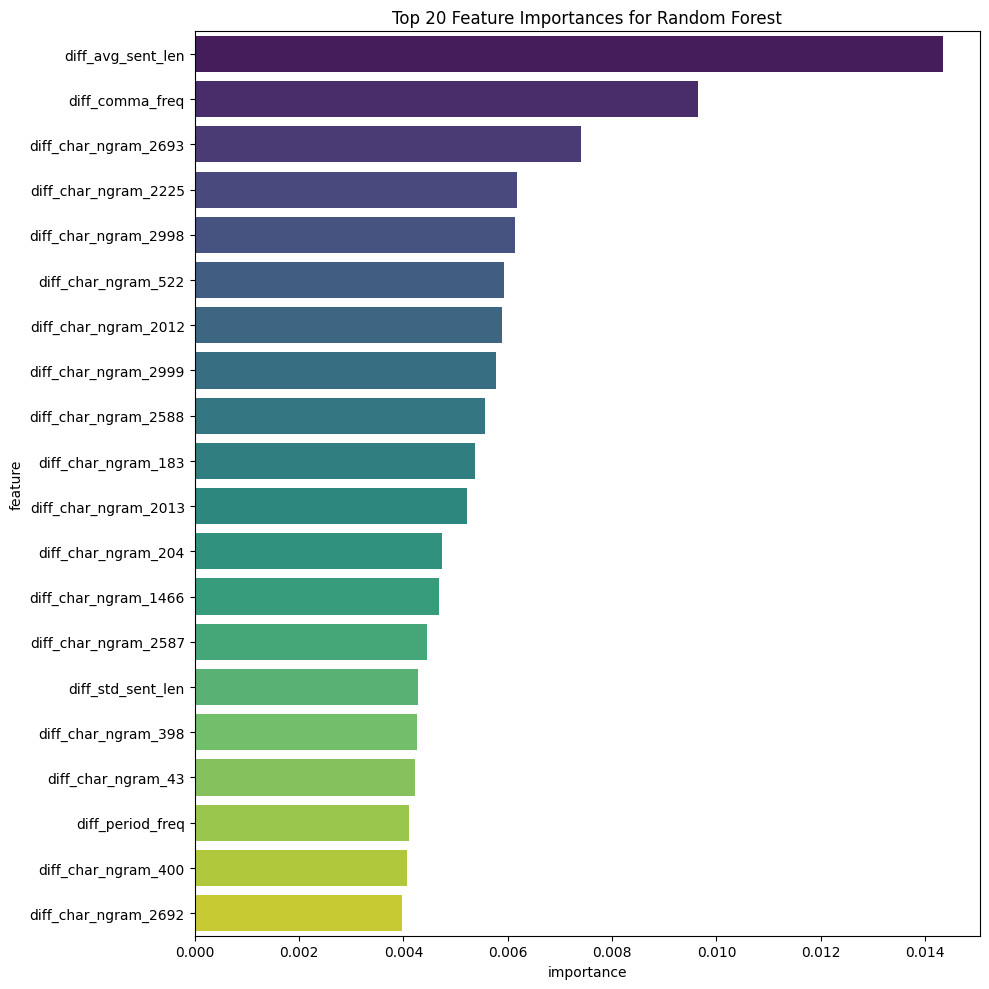


Processing: SVM (Linear Kernel)

--- Training SVM (Linear Kernel) ---
SVM (Linear Kernel) saved to saved_authorship_artifacts/svm_linear_kernel_model.joblib
Accuracy: 0.9333
Precision: 0.9042
Recall: 0.9693
F1-score: 0.9356
ROC AUC: 0.9821

--- Top 20 Absolute Feature Importances for SVM (Linear Kernel) ---
12. diff_std_sent_len: -0.1196 (Abs: 0.1196)
555. diff_char_ngram_539: -0.1121 (Abs: 0.1121)
3. diff_comma_freq: -0.1024 (Abs: 0.1024)
2101. diff_char_ngram_2085: -0.0880 (Abs: 0.0880)
1645. diff_char_ngram_1629: -0.0823 (Abs: 0.0823)
2594. diff_char_ngram_2578: 0.0791 (Abs: 0.0791)
1. diff_avg_sent_len: -0.0780 (Abs: 0.0780)
1020. diff_char_ngram_1004: -0.0766 (Abs: 0.0766)
5. diff_func_word_prop: -0.0756 (Abs: 0.0756)
199. diff_char_ngram_183: -0.0731 (Abs: 0.0731)
2855. diff_char_ngram_2839: 0.0713 (Abs: 0.0713)
708. diff_char_ngram_692: 0.0702 (Abs: 0.0702)
187. diff_char_ngram_171: -0.0696 (Abs: 0.0696)
2494. diff_char_ngram_2478: -0.0683 (Abs: 0.0683)
2297. diff_char_ngram_22

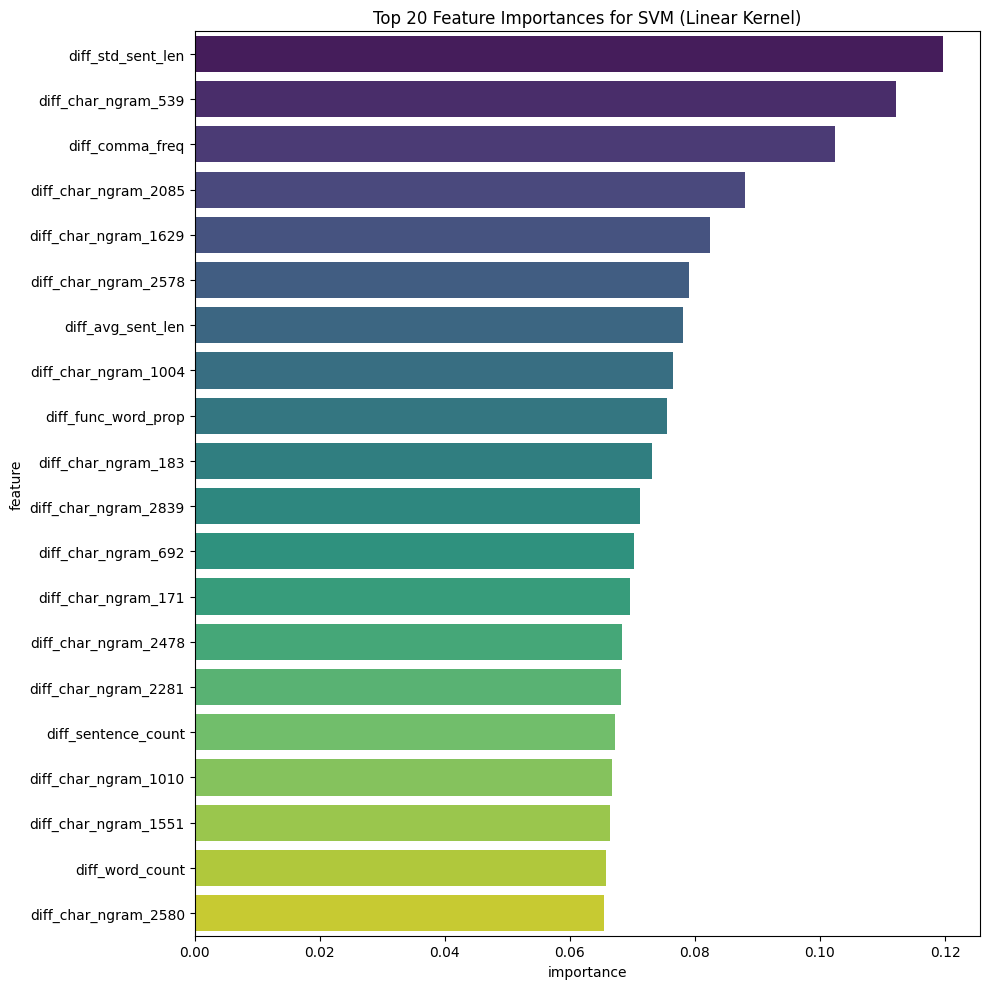


Processing: SVM (RBF Kernel)

--- Training SVM (RBF Kernel) ---
SVM (RBF Kernel) saved to saved_authorship_artifacts/svm_rbf_kernel_model.joblib
Accuracy: 0.9667
Precision: 0.9642
Recall: 0.9693
F1-score: 0.9668
ROC AUC: 0.9934

Processing: Gaussian Naive Bayes

--- Training Gaussian Naive Bayes ---
Gaussian Naive Bayes saved to saved_authorship_artifacts/gaussian_naive_bayes_model.joblib
Accuracy: 0.7313
Precision: 0.6917
Recall: 0.8347
F1-score: 0.7565
ROC AUC: 0.7531

Processing: XGBoost

--- Training XGBoost ---
XGBoost saved to saved_authorship_artifacts/xgboost_model.joblib
Accuracy: 0.9533
Precision: 0.9497
Recall: 0.9573
F1-score: 0.9535
ROC AUC: 0.9889

--- Top 20 Absolute Feature Importances for XGBoost ---
1436. diff_char_ngram_1420: 0.0107 (Abs: 0.0107)
2538. diff_char_ngram_2522: 0.0099 (Abs: 0.0099)
88. diff_char_ngram_72: 0.0090 (Abs: 0.0090)
2647. diff_char_ngram_2631: 0.0084 (Abs: 0.0084)
487. diff_char_ngram_471: 0.0084 (Abs: 0.0084)
2033. diff_char_ngram_2017: 0.007

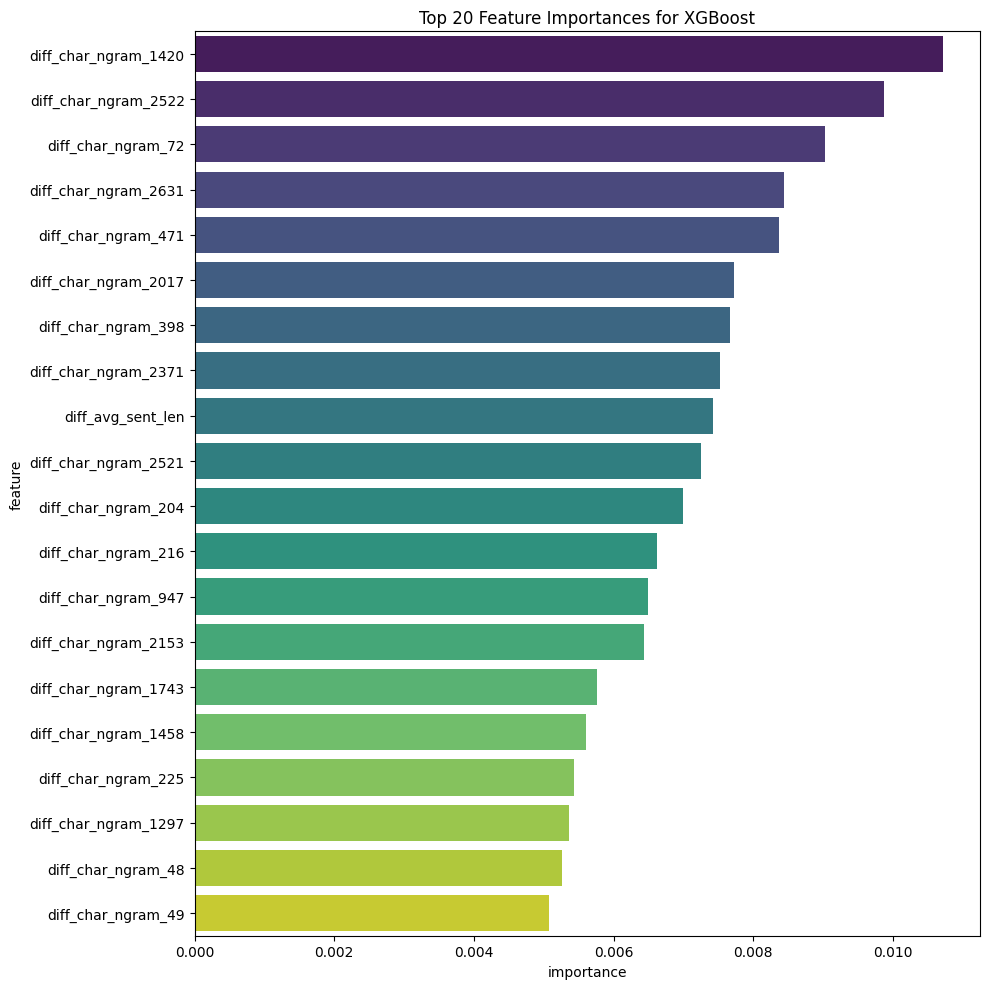

                  model  accuracy  precision    recall        f1   roc_auc
2      SVM (RBF Kernel)  0.966667   0.964191  0.969333  0.966755  0.993445
4               XGBoost  0.953333   0.949735  0.957333  0.953519  0.988907
0         Random Forest  0.950667   0.940104  0.962667  0.951252  0.985813
1   SVM (Linear Kernel)  0.933333   0.904229  0.969333  0.935650  0.982082
3  Gaussian Naive Bayes  0.731333   0.691713  0.834667  0.756495  0.753110


In [7]:

    ARTIFACTS_DIR = "saved_authorship_artifacts"
    if not os.path.exists(ARTIFACTS_DIR):
        os.makedirs(ARTIFACTS_DIR)
        print(f"Created directory: {ARTIFACTS_DIR}")

    print(f"Original dataset shape: {df_main.shape}")
    print(f"Class distribution:\n{df_main['same_author'].value_counts(normalize=True)}")
    if df_main['same_author'].nunique() < 2: raise ValueError("Target 'same_author' needs at least two classes.")
    
    X_paired_texts_df = df_main[['text1', 'text2']]
    y_labels = df_main['same_author']
    
    X_train_text_pairs_df, X_test_text_pairs_df, y_train_labels, y_test_labels = train_test_split(
        X_paired_texts_df, y_labels, test_size=0.25, random_state=42, stratify=y_labels
    )

    # --- 2. Feature Engineering & Save Vectorizer ---
    print("\n--- Feature Engineering on Training Data ---")
    X_train_features_df, fitted_char_ngram_vectorizer, feature_names_template = create_paired_features(
        X_train_text_pairs_df.copy(), fit_vectorizers_on_this_df=True, save_path_base=ARTIFACTS_DIR
    )
    print("\n--- Feature Engineering on Test Data (using fitted vectorizers) ---")
    X_test_features_df, _, _ = create_paired_features(
        X_test_text_pairs_df.copy(), char_ngram_vectorizer=fitted_char_ngram_vectorizer, fit_vectorizers_on_this_df=False
    )
    
    final_feature_names_with_diff = [f"diff_{name}" for name in feature_names_template]
    joblib.dump(final_feature_names_with_diff, os.path.join(ARTIFACTS_DIR, 'final_feature_names.joblib'))

    X_train_features_df.to_csv(os.path.join(ARTIFACTS_DIR, 'X_train_features.csv'), index=False)
    X_test_features_df.to_csv(os.path.join(ARTIFACTS_DIR, 'X_test_features.csv'), index=False)
    y_train_labels.to_csv(os.path.join(ARTIFACTS_DIR, 'y_train_labels.csv'), index=False, header=['same_author'])
    y_test_labels.to_csv(os.path.join(ARTIFACTS_DIR, 'y_test_labels.csv'), index=False, header=['same_author'])

    # --- 4. Scale features & Save Scaler ---
    scaler = StandardScaler() 
    X_train_scaled = scaler.fit_transform(X_train_features_df)
    X_test_scaled = scaler.transform(X_test_features_df)
    joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, 'scaler.joblib'))
    
    # Save scaled data as well (optional, as it can be regenerated from features + scaler)
    pd.DataFrame(X_train_scaled, columns=final_feature_names_with_diff).to_csv(os.path.join(ARTIFACTS_DIR, 'X_train_scaled_features.csv'), index=False)
    pd.DataFrame(X_test_scaled, columns=final_feature_names_with_diff).to_csv(os.path.join(ARTIFACTS_DIR, 'X_test_scaled_features.csv'), index=False)

    # --- 5. Model Training, Evaluation & Saving ---
    all_models_results = []
    models_to_train = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=2, class_weight='balanced'),
        "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
        "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
        "Gaussian Naive Bayes": GaussianNB(),
        "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
    }

    for model_name, model_instance in models_to_train.items():
        print(f"\nProcessing: {model_name}")
        # Determine if model needs scaled data
        if model_name in ["Random Forest", "XGBoost"]: # These are less sensitive to scaling
            X_train_data_for_model, X_test_data_for_model = X_train_features_df, X_test_features_df
        else: # Others generally benefit from or require scaling
            X_train_data_for_model, X_test_data_for_model = X_train_scaled, X_test_scaled
        
        res = train_and_evaluate_model(model_instance, X_train_data_for_model, y_train_labels, X_test_data_for_model, y_test_labels, model_name, save_path_base=ARTIFACTS_DIR)
        all_models_results.append(res)
        if model_name not in ["Gaussian Naive Bayes", "SVM (RBF Kernel)"]: # These might not have straightforward importance or it's handled differently
             display_feature_importance(res['trained_model'], final_feature_names_with_diff, model_name)
    
    results_summary_df = pd.DataFrame(all_models_results).drop(columns=['trained_model'])
    results_summary_df = results_summary_df.sort_values(by='f1', ascending=False)
    print(results_summary_df)
    results_summary_df.to_csv(os.path.join(ARTIFACTS_DIR, 'model_comparison_summary.csv'), index=False)